In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load Data
d = np.loadtxt('zeolite_rings_dpe.csv',delimiter = ',',dtype=object)

In [208]:
# Look at how the data is formatted
print(d[0])

['BEA' 'T1' 'O1' '12-12-12-5-4' '-1462.533633' '-1458.740431' '-3.793202'
 '' '15.3' '5.95' '5.95' '5.95' '20.52' '12-12-12-6-5-5-5-4-4'
 '12-12-12-12-6-6-6-6-6-6-5-5-5-5-5-5-4-4-4']


In [3]:
# Create function that will turn a ring list in to feature vector
def rings2features(r):
    r = r.split('-')
    f = np.zeros(20)
    for R in r:
        R = int(R)
        f[R]+=1
    return f

In [292]:
np.random.seed(1) # Set seed so this is reproducible
fws = ['BEA','CHA','FAU','FER','MFI','MOR']
xtrain = []
xtl = []
xvalidate = []
xvl = []
ytrain = []
yvalidate = []

ts = []
os = []
for f in fws:
    tmpts = []
    for line in d:
        if line[0] == f:
            tmpts.append(line[1])
    tmpts = np.array(tmpts)
    tmpts = np.unique(tmpts)
    ts.append(tmpts)
for i, f in enumerate(fws):
    on = []
    for j, t in enumerate(ts[i]):
        tmpos =[]
        for line in d:
            if line[0] ==f:
                if line[1] == t:
                    tmpos.append(line[2])
        on.append(len(tmpos))
    os.append(on)

for i, f in enumerate(fws):
    for j, t in enumerate(ts[i]):
        olines = []
        n = os[i][j]
        r = np.random.randint(n)
        for k, line in enumerate(d):
            if line[0]==f and line[1]==t:
                olines.append(k)
        line = d[olines[r]] 

        # label information
        temp = line[0:3]
        xvl.append(temp)

        # x data
        temp = rings2features(line[13])
        temp = list(temp)
        temp2 = rings2features(line[3])
        temp2 = list(temp2)
        temp3 = rings2features(line[14])
        temp3 = list(temp3)
        for p in temp2:
            temp.append(p)
        for p in temp3:
            temp.append(p)
        #                 for i in range(8,13):
        #                     temp.append(line[i])
        xvalidate.append(temp)

        # y data
        yvalidate.append([line[6]])
        
        del olines[r]
        
        for q in olines:
            line = d[q]
            # label information
            temp = line[0:3]
            xtl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            temp3 = rings2features(line[14])
            temp3 = list(temp3)
            for p in temp2:
                temp.append(p)
            for p in temp3:
                temp.append(p)
#                 for i in range(8,13):
#                     temp.append(line[i])
            xtrain.append(temp)

            #y data

            ytrain.append([line[6]])
            
            
xtrain = np.array(xtrain).astype(float)
xvalidate = np.array(xvalidate).astype(float)
ytrain = np.array(ytrain).astype(float)
yvalidate = np.array(yvalidate).astype(float)

xtrain = torch.tensor(xtrain)
xvalidate = torch.tensor(xvalidate)
ytrain = torch.tensor(ytrain)
yvalidate = torch.tensor(yvalidate)

xtrain = Variable(xtrain)
xvalidate = Variable(xvalidate)
ytrain = Variable(ytrain)
yvalidate = Variable(yvalidate)

training loss =  0.00010186359577346593
validating loss =  0.010280470363795757


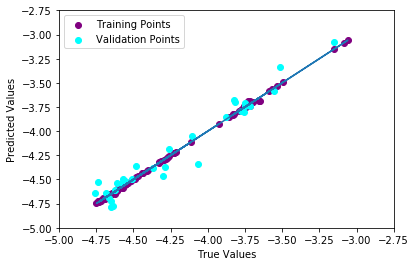

In [293]:
# Train the network
# Set network seed
torch.manual_seed(1);

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self,x):
        x = F.softsign(self.hidden(x))
        x = self.predict(x)
        return x
net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
loss_func = torch.nn.MSELoss()
for t in range(1000):
    prediction = net(xtrain.float())

    loss = loss_func(prediction,ytrain.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
# print loss values and plot training data
print('training loss = ',loss.item())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ytrain,ytrain)
ax.scatter(ytrain,prediction.data.numpy(),c='purple',label='Training Points')
ax.set_ylim([-5,-2.75])
ax.set_xlim([-5,-2.75])
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

# Validate the network
prediction = net(xvalidate.float())
loss = loss_func(prediction,yvalidate.float())

# print loss values and plot validating data
print('validating loss = ', loss.item())
ax.scatter(yvalidate,prediction.data.numpy(),c='cyan',label='Validation Points')
#ax.axis('square')
#ax.set_aspect('equal',adjustable='box')
ax.legend(loc='best')
fig.show()

In [205]:
yv = [x[0] for x in yvalidate.data.numpy()]
pv = [x[0] for x in prediction.data.numpy()]

from scipy import stats
s, i, r, p, std = stats.linregress(yv,pv)
print(s)
print(r**2)


lv = prediction - yvalidate
for i, l in enumerate(lv):
    if l > 0.05:
        print(xvl[i],lv.data.numpy()[i],yvalidate.data.numpy()[i])

1.0354482885454275
0.941477426579126
['BEA' 'T8' 'O16'] [0.16866078] [-3.82627]
['BEA' 'T9' 'O3'] [0.16231795] [-3.818819]
['CHA' 'T1' 'O1'] [0.16623339] [-3.511942]
['FAU' 'T1' 'O1'] [0.17533495] [-3.15062]
['MFI' 'T1' 'O16'] [0.24325121] [-4.480739]
['MFI' 'T11' 'O14'] [0.09366338] [-4.509391]
['MFI' 'T6' 'O6'] [0.13327313] [-4.7356]
['MFI' 'T7' 'O17'] [0.15672149] [-4.757378]
['MOR' 'T1' 'O2'] [0.12489321] [-4.257288]
['MOR' 'T4' 'O10'] [0.09380571] [-4.285695]


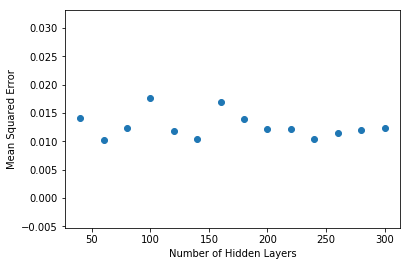

In [235]:
hid = [40,60,80,100,120,140,160,180,200,220,240,260,280,300]
tloss = []
vloss = []
for h in hid:
    # Get x and y train/validate data in torch form
    # ~70% of each framework for training
    # ~30% of each framework for validating
    torch.manual_seed(1);
    
    np.random.seed(1) # Set seed so this is reproducible
    fws = ['BEA','CHA','FAU','FER','MFI','MOR']
    xtrain = []
    xtl = []
    xvalidate = []
    xvl = []
    ytrain = []
    yvalidate = []

    ts = []
    os = []
    for f in fws:
        tmpts = []
        for line in d:
            if line[0] == f:
                tmpts.append(line[1])
        tmpts = np.array(tmpts)
        tmpts = np.unique(tmpts)
        ts.append(tmpts)
    for i, f in enumerate(fws):
        on = []
        for j, t in enumerate(ts[i]):
            tmpos =[]
            for line in d:
                if line[0] ==f:
                    if line[1] == t:
                        tmpos.append(line[2])
            on.append(len(tmpos))
        os.append(on)

    for i, f in enumerate(fws):
        for j, t in enumerate(ts[i]):
            olines = []
            n = os[i][j]
            r = np.random.randint(n)
            for k, line in enumerate(d):
                if line[0]==f and line[1]==t:
                    olines.append(k)
            line = d[olines[r]] 

            # label information
            temp = line[0:3]
            xvl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            temp3 = rings2features(line[14])
            temp3 = list(temp3)
            for p in temp2:
                temp.append(p)
            for p in temp3:
                temp.append(p)
            #                 for i in range(8,13):
            #                     temp.append(line[i])
            xvalidate.append(temp)

            # y data
            yvalidate.append([line[6]])

            del olines[r]

            for q in olines:
                line = d[q]
                # label information
                temp = line[0:3]
                xtl.append(temp)

                # x data
                temp = rings2features(line[13])
                temp = list(temp)
                temp2 = rings2features(line[3])
                temp2 = list(temp2)
                temp3 = rings2features(line[14])
                temp3 = list(temp3)
                for p in temp2:
                    temp.append(p)
                for p in temp3:
                    temp.append(p)
    #                 for i in range(8,13):
    #                     temp.append(line[i])
                xtrain.append(temp)

                #y data

                ytrain.append([line[6]])
            
            
    xtrain = np.array(xtrain).astype(float)
    xvalidate = np.array(xvalidate).astype(float)
    ytrain = np.array(ytrain).astype(float)
    yvalidate = np.array(yvalidate).astype(float)

    xtrain = torch.tensor(xtrain)
    xvalidate = torch.tensor(xvalidate)
    ytrain = torch.tensor(ytrain)
    yvalidate = torch.tensor(yvalidate)

    xtrain = Variable(xtrain)
    xvalidate = Variable(xvalidate)
    ytrain = Variable(ytrain)
    yvalidate = Variable(yvalidate)
    
    # Train the network
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.predict = torch.nn.Linear(n_hidden, n_output)

        def forward(self,x):
            x = F.softsign(self.hidden(x))
            x = self.predict(x)
            return x
    net = Net(n_feature = len(xtrain[0]), n_hidden = h, n_output=1)
    optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
    loss_func = torch.nn.MSELoss()
    for t in range(1000):
        prediction = net(xtrain.float())

        loss = loss_func(prediction,ytrain.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss.append(loss.item())
    
    # Validate the network
    prediction = net(xvalidate.float())
    loss = loss_func(prediction,yvalidate.float())
    vloss.append(loss.item())
plt.scatter(hid,vloss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of Hidden Layers')
plt.show()

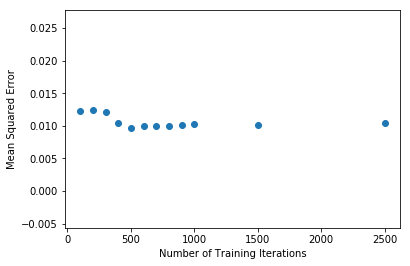

In [234]:
iters = [100,200,300,400,500,600,700,800,900,1000,1500,2500]
tloss = []
vloss = []
for b in iters:
    torch.manual_seed(1);
    np.random.seed(1) # Set seed so this is reproducible
    fws = ['BEA','CHA','FAU','FER','MFI','MOR']
    xtrain = []
    xtl = []
    xvalidate = []
    xvl = []
    ytrain = []
    yvalidate = []

    ts = []
    os = []
    for f in fws:
        tmpts = []
        for line in d:
            if line[0] == f:
                tmpts.append(line[1])
        tmpts = np.array(tmpts)
        tmpts = np.unique(tmpts)
        ts.append(tmpts)
    for i, f in enumerate(fws):
        on = []
        for j, t in enumerate(ts[i]):
            tmpos =[]
            for line in d:
                if line[0] ==f:
                    if line[1] == t:
                        tmpos.append(line[2])
            on.append(len(tmpos))
        os.append(on)

    for i, f in enumerate(fws):
        for j, t in enumerate(ts[i]):
            olines = []
            n = os[i][j]
            r = np.random.randint(n)
            for k, line in enumerate(d):
                if line[0]==f and line[1]==t:
                    olines.append(k)
            line = d[olines[r]] 

            # label information
            temp = line[0:3]
            xvl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            temp3 = rings2features(line[14])
            temp3 = list(temp3)
            for p in temp2:
                temp.append(p)
            for p in temp3:
                temp.append(p)
            #                 for i in range(8,13):
            #                     temp.append(line[i])
            xvalidate.append(temp)

            # y data
            yvalidate.append([line[6]])

            del olines[r]

            for q in olines:
                line = d[q]
                # label information
                temp = line[0:3]
                xtl.append(temp)

                # x data
                temp = rings2features(line[13])
                temp = list(temp)
                temp2 = rings2features(line[3])
                temp2 = list(temp2)
                temp3 = rings2features(line[14])
                temp3 = list(temp3)
                for p in temp2:
                    temp.append(p)
                for p in temp3:
                    temp.append(p)
    #                 for i in range(8,13):
    #                     temp.append(line[i])
                xtrain.append(temp)

                #y data

                ytrain.append([line[6]])
            
            
    xtrain = np.array(xtrain).astype(float)
    xvalidate = np.array(xvalidate).astype(float)
    ytrain = np.array(ytrain).astype(float)
    yvalidate = np.array(yvalidate).astype(float)

    xtrain = torch.tensor(xtrain)
    xvalidate = torch.tensor(xvalidate)
    ytrain = torch.tensor(ytrain)
    yvalidate = torch.tensor(yvalidate)

    xtrain = Variable(xtrain)
    xvalidate = Variable(xvalidate)
    ytrain = Variable(ytrain)
    yvalidate = Variable(yvalidate)
    
    
    # Train the network
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.predict = torch.nn.Linear(n_hidden, n_output)

        def forward(self,x):
            x = F.softsign(self.hidden(x))
            x = self.predict(x)
            return x
    net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
    optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
    loss_func = torch.nn.MSELoss()
    for t in range(b):
        prediction = net(xtrain.float())

        loss = loss_func(prediction,ytrain.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss.append(loss.item())
    
    # Validate the network
    prediction = net(xvalidate.float())
    loss = loss_func(prediction,yvalidate.float())
    vloss.append(loss.item())
plt.scatter(iters,vloss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of Training Iterations')
plt.show()

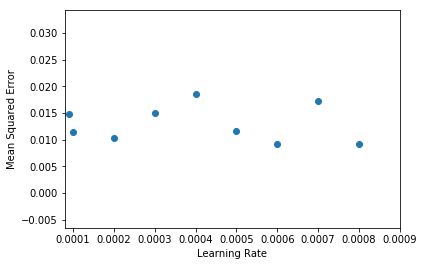

In [243]:
lr = [0.00009,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008]
tloss = []
vloss = []
for b in lr:
    torch.manual_seed(1);
    np.random.seed(1) # Set seed so this is reproducible
    fws = ['BEA','CHA','FAU','FER','MFI','MOR']
    xtrain = []
    xtl = []
    xvalidate = []
    xvl = []
    ytrain = []
    yvalidate = []

    ts = []
    os = []
    for f in fws:
        tmpts = []
        for line in d:
            if line[0] == f:
                tmpts.append(line[1])
        tmpts = np.array(tmpts)
        tmpts = np.unique(tmpts)
        ts.append(tmpts)
    for i, f in enumerate(fws):
        on = []
        for j, t in enumerate(ts[i]):
            tmpos =[]
            for line in d:
                if line[0] ==f:
                    if line[1] == t:
                        tmpos.append(line[2])
            on.append(len(tmpos))
        os.append(on)

    for i, f in enumerate(fws):
        for j, t in enumerate(ts[i]):
            olines = []
            n = os[i][j]
            r = np.random.randint(n)
            for k, line in enumerate(d):
                if line[0]==f and line[1]==t:
                    olines.append(k)
            line = d[olines[r]] 

            # label information
            temp = line[0:3]
            xvl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            temp3 = rings2features(line[14])
            temp3 = list(temp3)
            for p in temp2:
                temp.append(p)
            for p in temp3:
                temp.append(p)
            #                 for i in range(8,13):
            #                     temp.append(line[i])
            xvalidate.append(temp)

            # y data
            yvalidate.append([line[6]])

            del olines[r]

            for q in olines:
                line = d[q]
                # label information
                temp = line[0:3]
                xtl.append(temp)

                # x data
                temp = rings2features(line[13])
                temp = list(temp)
                temp2 = rings2features(line[3])
                temp2 = list(temp2)
                temp3 = rings2features(line[14])
                temp3 = list(temp3)
                for p in temp2:
                    temp.append(p)
                for p in temp3:
                    temp.append(p)
    #                 for i in range(8,13):
    #                     temp.append(line[i])
                xtrain.append(temp)

                #y data

                ytrain.append([line[6]])
            
            
    xtrain = np.array(xtrain).astype(float)
    xvalidate = np.array(xvalidate).astype(float)
    ytrain = np.array(ytrain).astype(float)
    yvalidate = np.array(yvalidate).astype(float)

    xtrain = torch.tensor(xtrain)
    xvalidate = torch.tensor(xvalidate)
    ytrain = torch.tensor(ytrain)
    yvalidate = torch.tensor(yvalidate)

    xtrain = Variable(xtrain)
    xvalidate = Variable(xvalidate)
    ytrain = Variable(ytrain)
    yvalidate = Variable(yvalidate)
    
    
    # Train the network
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.predict = torch.nn.Linear(n_hidden, n_output)

        def forward(self,x):
            x = F.softsign(self.hidden(x))
            x = self.predict(x)
            return x
    net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
    optimizer = torch.optim.Rprop(net.parameters(), lr = b)
    loss_func = torch.nn.MSELoss()
    for t in range(1000):
        prediction = net(xtrain.float())

        loss = loss_func(prediction,ytrain.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss.append(loss.item())
    
    # Validate the network
    prediction = net(xvalidate.float())
    loss = loss_func(prediction,yvalidate.float())
    vloss.append(loss.item())
plt.scatter(lr,vloss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Learning Rate')
plt.xlim([0.00008,0.0009])
plt.show()

In [244]:
print(vloss)

[0.014761410653591156, 0.011372478678822517, 0.010280470363795757, 0.014952481724321842, 0.018606852740049362, 0.011640045791864395, 0.009191756136715412, 0.017202183604240417, 0.009111645631492138]


In [217]:
# Get x and y train/validate data in torch form
# ~70% of total data set
# ~30% of total data set

np.random.seed(1) # Set seed so this is reproducible
fws = ['BEA','CHA','FAU','FER','MFI','MOR']
xtrain = []
xtl = []
xvalidate = []
xvl = []
ytrain = []
yvalidate = []

for line in d:
    r = np.random.random()
    if r >= 0.3:

        # label information
        temp = line[0:3]
        xtl.append(temp)

        # x data
        temp = rings2features(line[13])
        temp = list(temp)
        temp2 = rings2features(line[3])
        temp2 = list(temp2)
        for i in temp2:
            temp.append(i)
        for i in range(8,13):
            temp.append(line[i])
        xtrain.append(temp)

        #y data

        ytrain.append([line[6]])
    else:

        # label information
        temp = line[0:3]
        xvl.append(temp)

        # x data
        temp = rings2features(line[13])
        temp = list(temp)
        temp2 = rings2features(line[3])
        temp2 = list(temp2)
        for i in temp2:
            temp.append(i)
        for i in range(8,13):
            temp.append(line[i])
        xvalidate.append(temp)

        # y data
        yvalidate.append([line[6]])

xtrain = np.array(xtrain).astype(float)
xvalidate = np.array(xvalidate).astype(float)
ytrain = np.array(ytrain).astype(float)
yvalidate = np.array(yvalidate).astype(float)

xtrain = torch.tensor(xtrain)
xvalidate = torch.tensor(xvalidate)
ytrain = torch.tensor(ytrain)
yvalidate = torch.tensor(yvalidate)

xtrain = Variable(xtrain)
xvalidate = Variable(xvalidate)
ytrain = Variable(ytrain)
yvalidate = Variable(yvalidate)

training loss =  0.00010906825627898797
validating loss =  0.027457425370812416


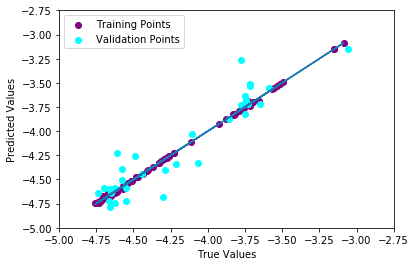

In [218]:
# Train the network
torch.manual_seed(3);
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self,x):
        x = F.softsign(self.hidden(x))
        x = self.predict(x)
        return x
net = Net(n_feature = len(xtrain[0]), n_hidden = 40, n_output=1)
optimizer = torch.optim.Rprop(net.parameters(),lr =0.0002)
loss_func = torch.nn.MSELoss()
for t in range(1000):
    prediction = net(xtrain.float())

    loss = loss_func(prediction,ytrain.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print('training loss = ',loss.item())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ytrain,ytrain)
ax.scatter(ytrain,prediction.data.numpy(),c='purple',label='Training Points')
ax.set_ylim([-5,-2.75])
ax.set_xlim([-5,-2.75])
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

# Validate the network
prediction = net(xvalidate.float())
loss = loss_func(prediction,yvalidate.float())
print('validating loss = ', loss.item())
ax.scatter(yvalidate,prediction.data.numpy(),c='cyan',label='Validation Points')
#ax.axis('square')
#ax.set_aspect('equal',adjustable='box')
ax.legend(loc='best')
fig.show()

In [214]:
# Train and validate with full data set


xtrain = []
xtl = []
ytrain = []

for line in d:

    # label information
    temp = line[0:3]
    xtl.append(temp)

    # x data
    temp = rings2features(line[13])
    temp = list(temp)
    temp2 = rings2features(line[3])
    temp2 = list(temp2)
    temp3 = rings2features(line[14])
    temp3 = list(temp3)
    for p in temp2:
        temp.append(p)
    for p in temp3:
        temp.append(p)
        
    xtrain.append(temp)

    #y data

    ytrain.append([line[6]])

xtrain = np.array(xtrain).astype(float)
ytrain = np.array(ytrain).astype(float)

xtrain = torch.tensor(xtrain)
ytrain = torch.tensor(ytrain)

xtrain = Variable(xtrain)
ytrain = Variable(ytrain)

training loss =  0.00010167473374167457


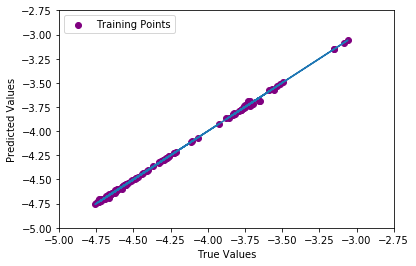

In [216]:
# Train the network
# Set network seed
torch.manual_seed(1);

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self,x):
        x = F.softsign(self.hidden(x))
        x = self.predict(x)
        return x
net = Net(n_feature = len(xtrain[0]), n_hidden = 180, n_output=1)
optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
loss_func = torch.nn.MSELoss()
for t in range(1000):
    prediction = net(xtrain.float())

    loss = loss_func(prediction,ytrain.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
# print loss values and plot training data
print('training loss = ',loss.item())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ytrain,ytrain)
ax.scatter(ytrain,prediction.data.numpy(),c='purple',label='Training Points')
ax.set_ylim([-5,-2.75])
ax.set_xlim([-5,-2.75])
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

ax.legend(loc='upper left')
fig.show()

In [263]:
# test a bunch of activation layers
activations = ['relu','hardtanh','relu6','elu','selu','celu','leaky_relu','prelu','rrelu','gelu','hardshrink']

# Get x and y train/validate data in torch form
# ~70% of each framework for training
# ~30% of each framework for validating
torch.manual_seed(1);

np.random.seed(1) # Set seed so this is reproducible
fws = ['BEA','CHA','FAU','FER','MFI','MOR']
xtrain = []
xtl = []
xvalidate = []
xvl = []
ytrain = []
yvalidate = []

ts = []
os = []
for f in fws:
    tmpts = []
    for line in d:
        if line[0] == f:
            tmpts.append(line[1])
    tmpts = np.array(tmpts)
    tmpts = np.unique(tmpts)
    ts.append(tmpts)
for i, f in enumerate(fws):
    on = []
    for j, t in enumerate(ts[i]):
        tmpos =[]
        for line in d:
            if line[0] ==f:
                if line[1] == t:
                    tmpos.append(line[2])
        on.append(len(tmpos))
    os.append(on)

for i, f in enumerate(fws):
    for j, t in enumerate(ts[i]):
        olines = []
        n = os[i][j]
        r = np.random.randint(n)
        for k, line in enumerate(d):
            if line[0]==f and line[1]==t:
                olines.append(k)
        line = d[olines[r]] 

        # label information
        temp = line[0:3]
        xvl.append(temp)

        # x data
        temp = rings2features(line[13])
        temp = list(temp)
        temp2 = rings2features(line[3])
        temp2 = list(temp2)
        temp3 = rings2features(line[14])
        temp3 = list(temp3)
        for p in temp2:
            temp.append(p)
        for p in temp3:
            temp.append(p)
        #                 for i in range(8,13):
        #                     temp.append(line[i])
        xvalidate.append(temp)

        # y data
        yvalidate.append([line[6]])

        del olines[r]

        for q in olines:
            line = d[q]
            # label information
            temp = line[0:3]
            xtl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            temp3 = rings2features(line[14])
            temp3 = list(temp3)
            for p in temp2:
                temp.append(p)
            for p in temp3:
                temp.append(p)
#                 for i in range(8,13):
#                     temp.append(line[i])
            xtrain.append(temp)

            #y data

            ytrain.append([line[6]])


xtrain = np.array(xtrain).astype(float)
xvalidate = np.array(xvalidate).astype(float)
ytrain = np.array(ytrain).astype(float)
yvalidate = np.array(yvalidate).astype(float)

xtrain = torch.tensor(xtrain)
xvalidate = torch.tensor(xvalidate)
ytrain = torch.tensor(ytrain)
yvalidate = torch.tensor(yvalidate)

xtrain = Variable(xtrain)
xvalidate = Variable(xvalidate)
ytrain = Variable(ytrain)
yvalidate = Variable(yvalidate)

# Train the network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self,x):
        x = F.softsign(self.hidden(x))
        x = self.predict(x)
        return x
net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
loss_func = torch.nn.MSELoss()
for t in range(1000):
    prediction = net(xtrain.float())

    loss = loss_func(prediction,ytrain.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
tloss.append(loss.item())

# Validate the network
prediction = net(xvalidate.float())
loss = loss_func(prediction,yvalidate.float())
print(loss.item())

0.010280470363795757


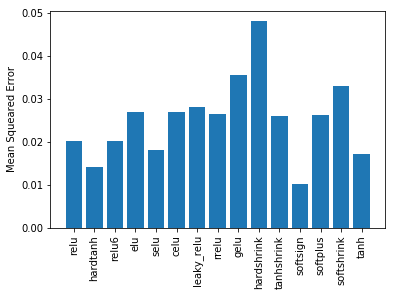

In [268]:
activations = ['relu','hardtanh','relu6','elu','selu','celu','leaky_relu','rrelu','gelu','hardshrink', 
               'tanhshrink','softsign','softplus','softshrink','tanh']
loss = [0.02018,0.014204,0.020181866,0.02699,0.0182006,0.026993,0.028143,0.026479037,0.0356553,0.048176184,
       0.02595623,0.01028047,0.0263906,0.0330196,0.01711557,]
plt.bar(activations,loss)
plt.xticks(rotation=90)
plt.ylabel('Mean Squeared Error')
plt.show()

In [290]:
# random number tester
np.random.seed(5)
seeds = np.random.randint(1000,size = 20)
losslist = []
# Get x and y train/validate data in torch form
# ~70% of each framework for training
# ~30% of each framework for validating
for s in seeds:
    torch.manual_seed(1);

    np.random.seed(s) # Set seed so this is reproducible
    fws = ['BEA','CHA','FAU','FER','MFI','MOR']
    xtrain = []
    xtl = []
    xvalidate = []
    xvl = []
    ytrain = []
    yvalidate = []

    ts = []
    os = []
    for f in fws:
        tmpts = []
        for line in d:
            if line[0] == f:
                tmpts.append(line[1])
        tmpts = np.array(tmpts)
        tmpts = np.unique(tmpts)
        ts.append(tmpts)
    for i, f in enumerate(fws):
        on = []
        for j, t in enumerate(ts[i]):
            tmpos =[]
            for line in d:
                if line[0] ==f:
                    if line[1] == t:
                        tmpos.append(line[2])
            on.append(len(tmpos))
        os.append(on)

    for i, f in enumerate(fws):
        for j, t in enumerate(ts[i]):
            olines = []
            n = os[i][j]
            r = np.random.randint(n)
            for k, line in enumerate(d):
                if line[0]==f and line[1]==t:
                    olines.append(k)
            line = d[olines[r]] 

            # label information
            temp = line[0:3]
            xvl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            temp3 = rings2features(line[14])
            temp3 = list(temp3)
            for p in temp2:
                temp.append(p)
            for p in temp3:
                temp.append(p)
            #                 for i in range(8,13):
            #                     temp.append(line[i])
            xvalidate.append(temp)

            # y data
            yvalidate.append([line[6]])

            del olines[r]

            for q in olines:
                line = d[q]
                # label information
                temp = line[0:3]
                xtl.append(temp)

                # x data
                temp = rings2features(line[13])
                temp = list(temp)
                temp2 = rings2features(line[3])
                temp2 = list(temp2)
                temp3 = rings2features(line[14])
                temp3 = list(temp3)
                for p in temp2:
                    temp.append(p)
                for p in temp3:
                    temp.append(p)
    #                 for i in range(8,13):
    #                     temp.append(line[i])
                xtrain.append(temp)

                #y data

                ytrain.append([line[6]])


    xtrain = np.array(xtrain).astype(float)
    xvalidate = np.array(xvalidate).astype(float)
    ytrain = np.array(ytrain).astype(float)
    yvalidate = np.array(yvalidate).astype(float)

    xtrain = torch.tensor(xtrain)
    xvalidate = torch.tensor(xvalidate)
    ytrain = torch.tensor(ytrain)
    yvalidate = torch.tensor(yvalidate)

    xtrain = Variable(xtrain)
    xvalidate = Variable(xvalidate)
    ytrain = Variable(ytrain)
    yvalidate = Variable(yvalidate)

    # Train the network
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.predict = torch.nn.Linear(n_hidden, n_output)

        def forward(self,x):
            x = F.softsign(self.hidden(x))
            x = self.predict(x)
            return x
    net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
    optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
    loss_func = torch.nn.MSELoss()
    for t in range(1000):
        prediction = net(xtrain.float())

        loss = loss_func(prediction,ytrain.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss.append(loss.item())

    # Validate the network
    prediction = net(xvalidate.float())
    loss = loss_func(prediction,yvalidate.float())
    losslist.append(loss.item())

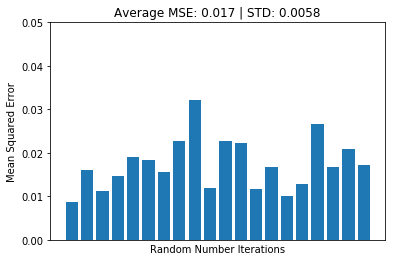

In [291]:
xloss = np.arange(1,21)
std = np.std(losslist)
av = np.average(losslist)
plt.bar(xloss,losslist)
plt.xticks([])
plt.xlabel('Random Number Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE: {0:.2} | STD: {1:.2}'.format(av,std))
plt.ylim(ymax=0.05)
plt.show() 

In [286]:
# random number tester
np.random.seed(5)
seeds = np.random.randint(1000,size = 20)
losslist = []
# Get x and y train/validate data in torch form
# ~70% of each framework for training
# ~30% of each framework for validating
for s in seeds:
    # Get x and y train/validate data in torch form
    # ~70% of total data set
    # ~30% of total data set

    np.random.seed(s) # Set seed so this is reproducible
    fws = ['BEA','CHA','FAU','FER','MFI','MOR']
    xtrain = []
    xtl = []
    xvalidate = []
    xvl = []
    ytrain = []
    yvalidate = []

    for line in d:
        r = np.random.random()
        if r >= 0.3:

            # label information
            temp = line[0:3]
            xtl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            for i in temp2:
                temp.append(i)
            for i in range(8,13):
                temp.append(line[i])
            xtrain.append(temp)

            #y data

            ytrain.append([line[6]])
        else:

            # label information
            temp = line[0:3]
            xvl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            for i in temp2:
                temp.append(i)
            for i in range(8,13):
                temp.append(line[i])
            xvalidate.append(temp)

            # y data
            yvalidate.append([line[6]])

    xtrain = np.array(xtrain).astype(float)
    xvalidate = np.array(xvalidate).astype(float)
    ytrain = np.array(ytrain).astype(float)
    yvalidate = np.array(yvalidate).astype(float)

    xtrain = torch.tensor(xtrain)
    xvalidate = torch.tensor(xvalidate)
    ytrain = torch.tensor(ytrain)
    yvalidate = torch.tensor(yvalidate)

    xtrain = Variable(xtrain)
    xvalidate = Variable(xvalidate)
    ytrain = Variable(ytrain)
    yvalidate = Variable(yvalidate)

    # Train the network
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.predict = torch.nn.Linear(n_hidden, n_output)

        def forward(self,x):
            x = F.softsign(self.hidden(x))
            x = self.predict(x)
            return x
    net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
    optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
    loss_func = torch.nn.MSELoss()
    for t in range(1000):
        prediction = net(xtrain.float())

        loss = loss_func(prediction,ytrain.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss.append(loss.item())

    # Validate the network
    prediction = net(xvalidate.float())
    loss = loss_func(prediction,yvalidate.float())
    losslist.append(loss.item())

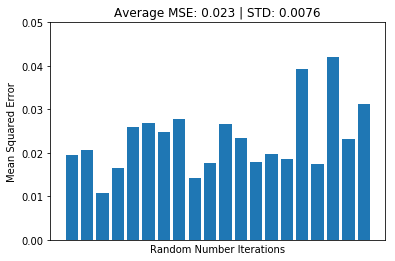

In [289]:
xloss = np.arange(1,21)
std = np.std(losslist)
av = np.average(losslist)
plt.bar(xloss,losslist)
plt.xticks([])
plt.xlabel('Random Number Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE: {0:.2} | STD: {1:.2}'.format(av,std))
plt.ylim(ymax=0.05)
plt.show() 

In [44]:
# amount of data tester

percents = np.arange(0.3,0.9,0.1)
losslist = []
tloss = []
# Get x and y train/validate data in torch form
# ~70% of each framework for training
# ~30% of each framework for validating
for per in percents:
    # Get x and y train/validate data in torch form
    # ~70% of total data set
    # ~30% of total data set

    #np.random.seed(3) # Set seed so this is reproducible
    fws = ['BEA','CHA','FAU','FER','MFI','MOR']
    xtrain = []
    xtl = []
    xvalidate = []
    xvl = []
    ytrain = []
    yvalidate = []

    for line in d:

        r = np.random.random()
        if r >= per:

            # label information
            temp = line[0:3]
            xtl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            for i in temp2:
                temp.append(i)
            for i in range(8,13):
                temp.append(line[i])
            xtrain.append(temp)

            #y data

            ytrain.append([line[6]])
        else:

            # label information
            temp = line[0:3]
            xvl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            for i in temp2:
                temp.append(i)
            for i in range(8,13):
                temp.append(line[i])
            xvalidate.append(temp)

            # y data
            yvalidate.append([line[6]])

    xtrain = np.array(xtrain).astype(float)
    xvalidate = np.array(xvalidate).astype(float)
    ytrain = np.array(ytrain).astype(float)
    yvalidate = np.array(yvalidate).astype(float)

    xtrain = torch.tensor(xtrain)
    xvalidate = torch.tensor(xvalidate)
    ytrain = torch.tensor(ytrain)
    yvalidate = torch.tensor(yvalidate)

    xtrain = Variable(xtrain)
    xvalidate = Variable(xvalidate)
    ytrain = Variable(ytrain)
    yvalidate = Variable(yvalidate)
    
    torch.manual_seed(1);
    
    # Train the network
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.predict = torch.nn.Linear(n_hidden, n_output)

        def forward(self,x):
            x = F.softsign(self.hidden(x))
            x = self.predict(x)
            return x
    net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
    optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
    loss_func = torch.nn.MSELoss()
    for t in range(1000):
        prediction = net(xtrain.float())

        loss = loss_func(prediction,ytrain.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss.append(loss.item())

    # Validate the network
    prediction = net(xvalidate.float())
    loss = loss_func(prediction,yvalidate.float())
    losslist.append(loss.item())

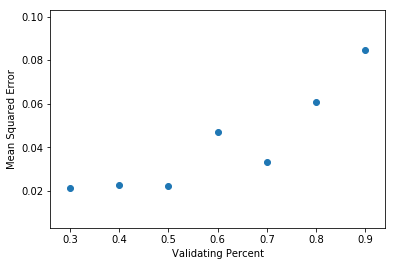

In [45]:
std = np.std(losslist)
av = np.average(losslist)
plt.scatter(percents,losslist)
plt.xlabel('Validating Percent')
plt.ylabel('Mean Squared Error')
plt.show() 

In [42]:
# amount of data tester

percents = np.arange(0.3,0.9,0.1)
losslist = []
tloss = []
fws = ['BEA','CHA','FAU','FER','MFI','MOR']
# Get x and y train/validate data in torch form
# ~70% of each framework for training
# ~30% of each framework for validating
for fw in fws:
    # Get x and y train/validate data in torch form
    # ~70% of total data set
    # ~30% of total data set

    #np.random.seed(1) # Set seed so this is reproducible

    xtrain = []
    xtl = []
    xvalidate = []
    xvl = []
    ytrain = []
    yvalidate = []

    for line in d:
        r = np.random.random()
        if line[0] != fw:

            # label information
            temp = line[0:3]
            xtl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            for i in temp2:
                temp.append(i)
            for i in range(8,13):
                temp.append(line[i])
            xtrain.append(temp)

            #y data

            ytrain.append([line[6]])
        else:

            # label information
            temp = line[0:3]
            xvl.append(temp)

            # x data
            temp = rings2features(line[13])
            temp = list(temp)
            temp2 = rings2features(line[3])
            temp2 = list(temp2)
            for i in temp2:
                temp.append(i)
            for i in range(8,13):
                temp.append(line[i])
            xvalidate.append(temp)

            # y data
            yvalidate.append([line[6]])

    xtrain = np.array(xtrain).astype(float)
    xvalidate = np.array(xvalidate).astype(float)
    ytrain = np.array(ytrain).astype(float)
    yvalidate = np.array(yvalidate).astype(float)

    xtrain = torch.tensor(xtrain)
    xvalidate = torch.tensor(xvalidate)
    ytrain = torch.tensor(ytrain)
    yvalidate = torch.tensor(yvalidate)

    xtrain = Variable(xtrain)
    xvalidate = Variable(xvalidate)
    ytrain = Variable(ytrain)
    yvalidate = Variable(yvalidate)
    
    torch.manual_seed(1);
    
    # Train the network
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.predict = torch.nn.Linear(n_hidden, n_output)

        def forward(self,x):
            x = F.softsign(self.hidden(x))
            x = self.predict(x)
            return x
    net = Net(n_feature = len(xtrain[0]), n_hidden = 60, n_output=1)
    optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)
    loss_func = torch.nn.MSELoss()
    for t in range(1000):
        prediction = net(xtrain.float())

        loss = loss_func(prediction,ytrain.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss.append(loss.item())

    # Validate the network
    prediction = net(xvalidate.float())
    loss = loss_func(prediction,yvalidate.float())
    losslist.append(loss.item())

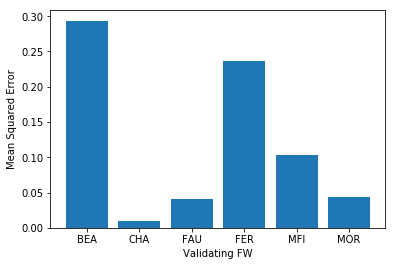

In [43]:
std = np.std(losslist)
av = np.average(losslist)
plt.bar(fws,losslist)
plt.xlabel('Validating FW')
plt.ylabel('Mean Squared Error')
plt.show() 